# Interest Rate Risk

_The essence of investment management is the management of risks, not the management of returns_ - Benjamin Graham 

Changes in interest rates directly affect the value of bonds and fixed-income portfolios. Various measures of interest rate sensitivity, such as duration, convexity, DV01, and key rate shifts help quantify how bond prices respond to fluctations in the yield curve. Additionally, we explore the statistical approach to identifying key risk factors that explain interest rate movements.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
from typing import List
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from finds.readers import Alfred
from finds.recipes import bond_price
from secret import credentials
# %matplotlib qt
VERBOSE = 0

## Interest rate sensitivity

### Duration

Duration, or **Macaulay Duration**, measures how a bond’s price $ P $ changes in response to an instantaneous change in its yield $ y $.  

Consider a bond with price $ P $ and yield $ y $. To simplify the duration formula, we first express the yield using continuous compounding. The bond’s price is given by:  

$$
P = \sum_{t=1}^{n} c_t e^{-yt}
$$

Differentiating this equation, we obtain:  

$$
\Delta P = -\sum_{t=1}^{n} c_t t e^{-yt} \Delta y
$$

**Yield-based duration** is defined as the proportional change in bond price for a small change in yield:  

$$
D = \dfrac{\Delta P}{P \Delta y} = \sum_{t=1}^{n} t \dfrac{c_t e^{-yt}}{P}
$$

This formulation provides an alternative interpretation of duration: it represents the weighted average time at which cash flows are received, with each time weighted by the proportion of the bond’s total value received at that time. This explains why the term "duration" is used to describe sensitivity to yield changes—duration effectively measures how long an investor must wait to receive the bond’s cash flows.  

**Modified duration** accounts for different compounding conventions. If yields are measured with semi-annual compounding instead of continuous compounding, Macaulay duration must be adjusted by dividing by $ (1 + y_2/2) $ (or $ 1 + y_m/m $ for $ m $-thly compounding).  

**Effective duration**, on the other hand, measures the percentage change in the price of a bond with embedded options due to a small shift in all interest rates.  



### DV01

**DV01** (Dollar Value of a 01) quantifies the impact of a one-basis-point change in interest rates on a bond or portfolio’s value. It is given by:  

$$
DV01 = -\dfrac{\Delta P}{\Delta r}
$$

where $ \Delta r $ represents a small parallel shift in the interest rate term structure (expressed in basis points).  



### Convexity

Duration and convexity appear as the first two terms in a Taylor expansion of a bond’s price with respect to interest rates. While duration provides a linear estimate of price sensitivity, convexity measures the curvature of the bond price-yield relationship, refining estimates for larger rate movements.  

Convexity accounts for the fact that bond price changes are not perfectly linear with respect to interest rate movements. **Yield-based convexity**, when yields are expressed with continuous compounding, is given by:  

$$
C = \frac{1}{P}\frac{1}{(1+r/m)^2}\sum_{t=1}^{T}(t/2m +(t/m)^2)\frac{C_t}{(1+r/m)^t}
$$

This formula represents a weighted average of the squared time to maturity. When yields are expressed with semi-annual compounding, these expressions must be divided by $ (1 + y_2/2)^2 $ (or $ (1 + y_m/m)^2 $ for $ m $-thly compounding), and the result is known as **modified convexity**.  

**Effective convexity** measures how duration itself changes in response to interest rate shifts and is calculated as:  

$$
C = \dfrac{1}{P}[\dfrac{P^+ + P^- - 2P}{(\Delta r)^2}]
$$


In [2]:
# Helpers to calculate duration and convexity
def macaulay_duration(coupon: float, n: int, m: int, price: float, 
                      yields: float | List[float], par: float = 1, **kwargs) -> float:
    """Compute macaulay duration of a bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      price : current market price of bond
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Macaulay duration
    """
    if not pd.api.types.is_list_like(yields):
        yields = [yields] * n        # same spot rate every period
    assert len(yields) == n, "Number of spot rates must equal number of couponds"
    pv = [(1 + yields[t-1]/m)**(-t) * (t/m) * (coupon/m + par*(t == n))
          for t in range(1, n+1)]    # discount every period's time-weighted payment
    return np.sum(pv) / price

In [3]:
def modified_duration(coupon: float, n: int, m: int, price: float, 
                      yields: float | List[float], par: float = 1, **kwargs) -> float:
    """Compute modified duration of a bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      price : current market price of bond
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Modified duration
    """
    assert not pd.api.types.is_list_like(yields), "Not Implemented"
    ytm = yields
    return (macaulay_duration(coupon=coupon, n=n, m=m, price=price, yields=yields, par=par)
            / (1 + ytm/2))

In [4]:
def modified_convexity(coupon: float, n: int, m: int, price: float, 
                       yields: float | List[float], par: float = 1, **kwargs) -> float:
    """Compute mocified convexity of a bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      price : current market price of bond
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Modified convexity
    """
    assert not pd.api.types.is_list_like(yields), "Not Implemented"
    ytm = yields
    if not pd.api.types.is_list_like(yields):
        yields = [yields] * n        # same spot rate every period
    assert len(yields) == n, "Number of spot rates must equal number of coupons"
    pv = [(1 + yields[t-1]/m)**(-t) * ((t/m)**2 + t/(2*m)) * (coupon/m + par*(t == n))
          for t in range(1, n+1)]    # discount every period's time-weighted payment
    return np.sum(pv) / (price * (1 + ytm/m)**2)

### Barbells and bullets

**Positive convexity** benefits bondholders when there is a parallel shift in interest rates. Consider two fixed-income strategies:  

- A barbell strategy, which consists of holding short- and long-maturity bonds  
- A bullet strategy, which focuses on medium-term bonds  

Both strategies may have the same yield (4%) and duration (8.1758), but the barbell strategy typically outperforms when interest rates shift in parallel. This creates an arbitrage opportunity:  

1. Invest a given USD amount in the barbell strategy  
2. Short the same USD amount in the bullet strategy  

If term structure shifts were always parallel, this approach would be consistently profitable.  


In [5]:
# Compute prices, duration and convexity for 3 bonds (FRM Valuation and Risk Models 12.7)
bond5Y = dict(coupon=2, m=2, n=2*5, par=100, yields=0.04)
bond10Y = dict(coupon=4, m=2, n=2*10, par=100, yields=0.04)
bond20Y = dict(coupon=6, m=2, n=2*20, par=100, yields=0.04)
for bond in [bond5Y, bond10Y, bond20Y]:
    bond |= dict(price=bond_price(**bond))
    bond |= dict(duration=modified_duration(**bond))
    bond |= dict(convexity=modified_convexity(**bond))
bonds = DataFrame.from_dict(
    {f"{b['n']/b['m']:.0f}-year, {b['coupon']}% coupon": [
        b['price'], b['duration'], b['convexity']]
     for b in [bond5Y, bond10Y, bond20Y]},
    orient='index',
    columns=['Value', 'Effective Duration', 'Effective Convexity'])

In [6]:
print("Table 12.4 Effective Durations and Convexities of Three Bonds")
bonds.round(4)

Table 12.4 Effective Durations and Convexities of Three Bonds


,Value,Effective Duration,Effective Convexity
"5-year, 2% coupon",91.0174,4.6764,24.8208
"10-year, 4% coupon",100.0000,8.1757,78.8979
"20-year, 6% coupon",127.3555,12.6233,212.4587


In [7]:
# Compute 5Y and 20Y weights of barbell portfolio, with same duration as bullet 10Y
barbell = ((bond10Y['duration'] - bond20Y['duration']) /
           (bond5Y['duration'] - bond20Y['duration']))
print(f"Barbell: weight in 5Y = {barbell:.4f}, weight in 20Y = {1-barbell:.4f}")

Barbell: weight in 5Y = 0.5597, weight in 20Y = 0.4403


In [8]:
# Compare durations and convexities
DataFrame.from_dict(dict(Bullet=np.array([0,1,0]).dot(bonds),
                         Barbell=np.array([barbell, 0, 1-barbell]).dot(bonds)),
                    orient='index', columns=bonds.columns)\
                    [['Effective Duration', 'Effective Convexity']]

,Effective Duration,Effective Convexity
Bullet,8.175717,78.897925
Barbell,8.175717,107.444902


### Key rate shifts 

Consider three key spot rates: the two-year, five-year, and ten-year rates. Each influences rates in its surrounding maturity range, and together, their combined movements contribute to an overall one-basis-point shift in the yield curve.  

These shifts, known as **key rate shifts**, allow for a more detailed decomposition of DV01. The impact of these shifts is captured by **partial 01s** or **key rate 01s (KR01s)**, defined as follows:  

- **KR01₁**: The reduction in portfolio value from a one-basis-point increase in the two-year spot rate  
- **KR01₂**: The reduction in portfolio value from a one-basis-point increase in the five-year spot rate  
- **KR01₃**: The reduction in portfolio value from a one-basis-point increase in the ten-year spot rate  

Since these shifts sum to the overall DV01, we have:  

$$
DV01 = KR01_1 + KR01_2 + KR01_3
$$

By analyzing these key rate sensitivities, investors can better estimate portfolio values under various term structure movements and hedge against specific interest rate risks.  

In [9]:
KR = [2, 5, 10]
DV01 = dict()
for maturity in np.arange(0, 15, 0.5):
    if maturity <= KR[0]:
        changes = [1, 0, 0]
    elif maturity >= KR[2]:
        changes = [0, 0, 1]
    elif maturity < KR[1]:
        diff = (maturity - KR[0])/(KR[1] - KR[0])
        changes = [1 - diff, diff, 0]
    else:
        diff = (KR[2] - maturity)/(KR[2] - KR[1])
        changes = [0, diff, 1-diff]
    DV01[maturity] = changes

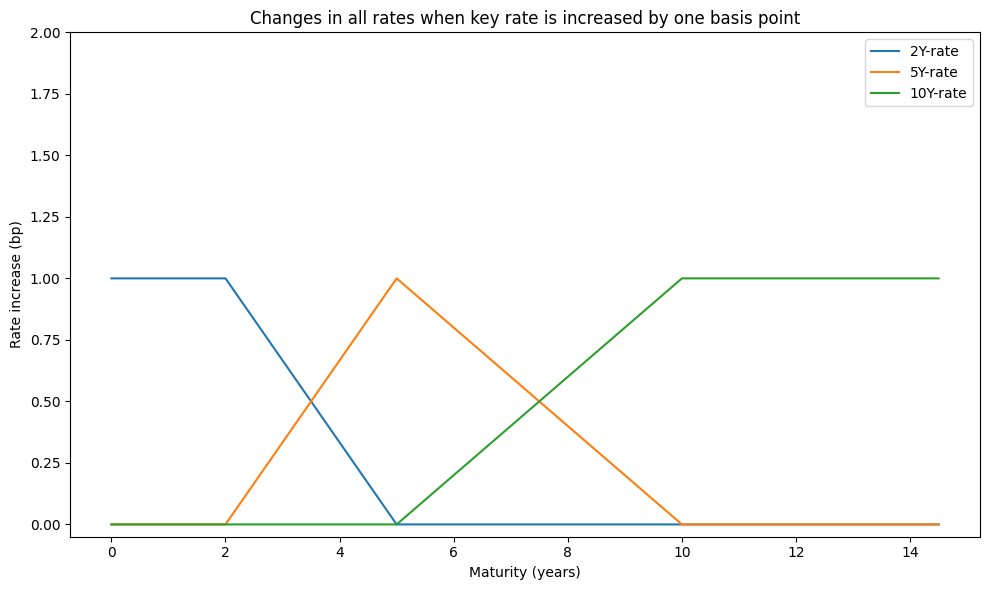

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
DataFrame.from_dict(DV01, orient='index', columns=[f"{y}Y-rate" for y in KR])\
         .plot(ax=ax)
ax.legend()
ax.set_title('Changes in all rates when key rate is increased by one basis point')
ax.set_ylabel('Rate increase (bp)')
ax.set_xlabel('Maturity (years)')
ax.set_ylim(top=2)
plt.tight_layout()

## Risk factors

We examine the risk factors which drive the daily returns of the Merrill Lynch Total Bond Indexes.

In [11]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)

In [12]:
# get Merrill Lynch bond indexes
freq = 'D'    # periodicity 'M' or 'D'
cat = alf.get_category(32413)
print(cat['id'], cat['name'])

32413 BofA Merrill Lynch Total Bond Return Index Values


In [13]:
# get bond index returns
bonds = []   # to accumulate bond returns
for s in cat['series']:
    bonds.append(alf(s['id'], start=19961231, freq=freq) )
bonds_df = pd.concat(bonds, axis=1).sort_index()

In [14]:
# show blocks of data availability
counts = bonds_df.notna().sum(axis=1).rename('count')
counts = pd.concat([counts, (counts != counts.shift()).cumsum().rename('notna')], axis=1)
counts = counts.reset_index().groupby(['notna', 'count'])['date'].agg(['first','last'])
counts

,,first,last
notna,count,,
1,15,19961231,19971230
2,16,19971231,19981230
3,33,19981231,20031230
4,48,20031231,20181108
5,46,20181109,20181109
6,48,20181112,20250228


Choose start date with good data availability

In [31]:
start_date = 19981231
rets = bonds_df.loc[bonds_df.index >= start_date,
                    bonds_df.loc[start_date].notna().values].iloc[:-1]
rets = pd.concat([alf.transform(rets[col], log=1, diff=1)
                  for col in rets.columns], axis=1).dropna()
date_str = f" ({rets.index[0]}-{rets.index[-1]})"
rets

,BAMLCC0A0CMTRIV,BAMLCC0A1AAATRIV,BAMLCC0A2AATRIV,BAMLCC0A3ATRIV,BAMLCC0A4BBBTRIV,BAMLCC1A013YTRIV,BAMLCC2A035YTRIV,BAMLCC3A057YTRIV,BAMLCC4A0710YTRIV,BAMLCC7A01015YTRIV,...,BAMLEMPTPRVICRPITRIV,BAMLEMRACRPIASIATRIV,BAMLEMRECRPIEMEATRIV,BAMLEMRLCRPILATRIV,BAMLEMUBCRPIUSTRIV,BAMLHE00EHYITRIV,BAMLHYH0A0HYM2TRIV,BAMLHYH0A1BBTRIV,BAMLHYH0A2BTRIV,BAMLHYH0A3CMTRIV
date,,,,,,,,,,,,,,,,,,,,,
19990104,-0.001053,-0.001421,-0.000660,-0.001166,-0.000995,0.000076,0.000473,0.000534,-0.000519,-0.001209,...,0.001599,-0.000700,-0.005616,0.002297,0.001099,0.000195,0.001490,0.000250,0.001999,0.003234
19990105,-0.003846,-0.004194,-0.003500,-0.003857,-0.003952,-0.000844,-0.002452,-0.003343,-0.004276,-0.004990,...,0.002692,0.000400,0.008113,0.002392,0.002394,0.012287,0.000674,-0.000834,0.000781,0.005428
19990106,0.002388,0.002099,0.002102,0.002495,0.002419,0.000466,0.000901,0.001695,0.001967,0.002537,...,0.007144,0.003395,0.009135,0.006251,0.006060,0.000577,0.001487,0.001583,0.001041,0.003480
19990107,-0.002694,-0.002813,-0.002413,-0.002573,-0.002996,0.000101,-0.000853,-0.001561,-0.002662,-0.003371,...,-0.001484,-0.003095,0.007386,0.000198,-0.000694,0.003932,-0.000112,-0.001250,0.000520,0.001005
19990108,-0.002583,-0.002941,-0.002419,-0.002658,-0.002504,-0.000920,-0.002006,-0.003309,-0.003773,-0.004368,...,-0.000594,0.001998,0.000392,-0.002079,-0.000892,0.000000,0.001737,-0.000918,0.002509,0.007643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250221,0.004058,0.005418,0.004519,0.004090,0.003918,0.001278,0.002482,0.003648,0.004107,0.005264,...,0.001815,0.002360,0.001548,0.001954,0.002056,0.000502,-0.000726,-0.000524,-0.001033,-0.000715
20250224,0.001879,0.002273,0.001855,0.001842,0.001917,0.000683,0.001165,0.001481,0.001797,0.002408,...,0.001124,0.001355,0.001095,0.000737,0.001161,0.000422,0.001040,0.001016,0.001033,0.001213
20250225,0.005450,0.007181,0.006098,0.005468,0.005274,0.001025,0.002846,0.004326,0.005516,0.007383,...,0.002267,0.003170,0.002267,0.002544,0.002939,0.000026,0.001028,0.001456,0.000758,-0.000062


Select these bond return indexes

In [32]:
pd.set_option('display.max_colwidth', None)
print("Bond Index Total Returns")
Series(alf.header(rets.columns), index=rets.columns, name='title')\
    .to_frame().rename_axis('series')

Bond Index Total Returns


,title
series,
BAMLCC0A0CMTRIV,ICE BofA US Corporate Index Total Return Index Value
BAMLCC0A1AAATRIV,ICE BofA AAA US Corporate Index Total Return Index Value
BAMLCC0A2AATRIV,ICE BofA AA US Corporate Index Total Return Index Value
BAMLCC0A3ATRIV,ICE BofA Single-A US Corporate Index Total Return Index Value
BAMLCC0A4BBBTRIV,ICE BofA BBB US Corporate Index Total Return Index Value
BAMLCC1A013YTRIV,ICE BofA 1-3 Year US Corporate Index Total Return Index Value
BAMLCC2A035YTRIV,ICE BofA 3-5 Year US Corporate Index Total Return Index Value
BAMLCC3A057YTRIV,ICE BofA 5-7 Year US Corporate Index Total Return Index Value
BAMLCC4A0710YTRIV,ICE BofA 7-10 Year US Corporate Index Total Return Index Value


### Statistical risk factors

Extract principal components of bond index returns

In [33]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pipe.fit(rets)
print(pipe.named_steps['pca'].explained_variance_ratio_)  # sanity check
scree = Series(pipe.named_steps['pca'].explained_variance_ratio_,
               index=np.arange(1, rets.shape[1]+1))
DataFrame(scree.cumsum().rename('Cumulative Variance Ratio Explained')).iloc[:10]

[5.93480704e-01 1.83414224e-01 7.60999397e-02 2.29460554e-02
 2.08374926e-02 1.73252063e-02 1.58102554e-02 1.11222261e-02
 1.07270153e-02 9.46337690e-03 7.12268856e-03 5.78660305e-03
 5.08617829e-03 4.56329291e-03 3.87130739e-03 2.53236096e-03
 2.40159698e-03 2.17255450e-03 1.28094767e-03 9.31393646e-04
 7.70330791e-04 6.01123712e-04 3.93600105e-04 3.60165273e-04
 3.03684121e-04 2.70804862e-04 9.27216331e-05 8.30786301e-05
 5.32780919e-05 3.92254907e-05 3.55714421e-05 1.53907425e-05
 5.60549950e-06]


,Cumulative Variance Ratio Explained
1,0.593481
2,0.776895
3,0.852995
4,0.875941
5,0.896778
6,0.914104
7,0.929914
8,0.941036
9,0.951763
10,0.961226


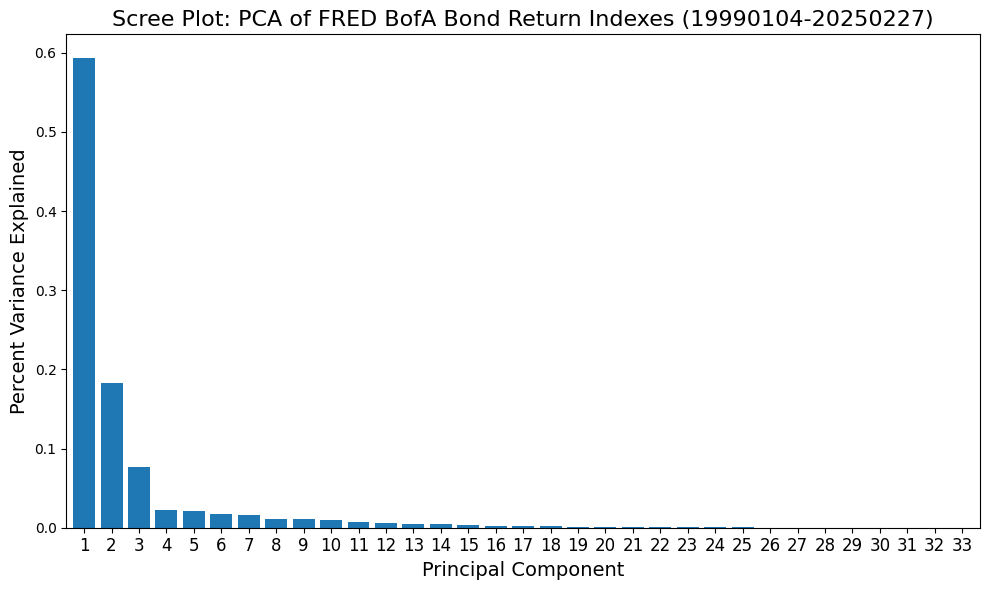

In [34]:
# Scree plot
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
scree.plot(kind='bar', rot=0, width=.8, ax=ax)
ax.set_title('Scree Plot: PCA of FRED BofA Bond Return Indexes' + date_str, fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_ylabel("Percent Variance Explained", fontsize=14)
ax.set_xlabel("Principal Component", fontsize=14)
plt.tight_layout()

### Explainability of statistical risk factors

In [35]:
# Extract factor returns from bond indexes with PCA projection
K = 4
factors = DataFrame(pipe.transform(rets)[:, :K],
                    columns=[f"PC{c+1}" for c in range(K)],
                    index=pd.DatetimeIndex(rets.index.astype(str), freq='infer'))

Construct interest rate spreads to compare with the statistical factors:

- **Level**: The average of the two-year and ten-year Treasury rates  
- **Slope**: The difference between the ten-year and two-year Treasury rates  
- **Twist**: The difference between (ten-year minus five-year) and (five-year minus two-year) rates  
- **Credit Spread**: The difference between BAA corporate bond yields and ten-year Treasury rates  

In [36]:
# Construct interest rate spread changes
spreads = pd.concat([alf(s, freq=freq) for s in ['BAA10Y', 'DGS10', 'DGS5', 'DGS2']],
                     axis=1)\
            .sort_index()
spreads.index = pd.DatetimeIndex(spreads.index.astype(str), freq='infer')
spreads['level'] = 0.5 * (spreads['DGS2'] + spreads['DGS10'])
spreads['credit'] = spreads['BAA10Y']
spreads['slope'] = spreads['DGS10'] - spreads['DGS2']
spreads['twist'] = ((spreads['DGS10'] - spreads['DGS5']) -
                    (spreads['DGS5'] - spreads['DGS2']))
spreads = spreads.drop(columns=['BAA10Y', 'DGS10', 'DGS5', 'DGS2'])\
                 .ffill()\
                 .diff()\
                 .dropna()
spreads

,level,credit,slope,twist
date,,,,
1986-01-03,0.010,-0.04,1.776357e-15,1.776357e-15
1986-01-06,0.015,-0.01,1.000000e-02,-1.000000e-02
1986-01-07,-0.100,0.06,-6.000000e-02,-8.881784e-16
1986-01-08,0.155,-0.14,7.000000e-02,3.000000e-02
1986-01-09,0.160,-0.05,-4.000000e-02,-8.000000e-02
...,...,...,...,...
2025-02-24,-0.040,-0.01,4.000000e-02,-2.000000e-02
2025-02-25,-0.080,0.02,-4.000000e-02,6.000000e-02
2025-02-26,-0.035,0.01,-3.000000e-02,5.000000e-02


Text(0.5, 1.0, 'Correlation of bond factors and interest rate spread changes')

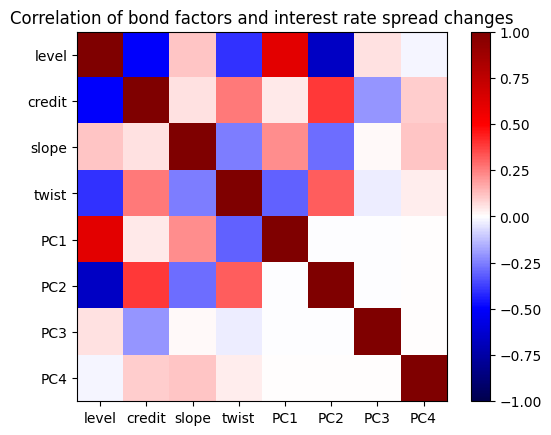

In [37]:
# Show correlations between bond factor returns and spread changes
data = pd.concat([spreads, factors], axis=1, join='inner')
corr = data.corr()
#plt.imshow(corr**2, vmin=0, vmax=1, cmap='Purples')
plt.imshow(corr, vmin=-1, vmax=1, cmap='seismic')
plt.xticks(range(len(corr)), corr.index)
plt.yticks(range(len(corr)), corr.index)
plt.colorbar()
plt.title('Correlation of bond factors and interest rate spread changes')


In [38]:
# Show regression fits
for pc in range(K):
    print(smf.ols(f"PC{pc+1} ~ credit + level + slope + twist", data=data)\
          .fit(cov_type='HAC', cov_kwds={'maxlags': 63})\
          .summary())

                            OLS Regression Results                            
Dep. Variable:                    PC1   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     449.8
Date:                Mon, 03 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:15:31   Log-Likelihood:                -16545.
No. Observations:                6533   AIC:                         3.310e+04
Df Residuals:                    6528   BIC:                         3.313e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0260      0.089      0.293      0.7

**References:**

FRM Part I Exam Book Valuation and Risk Models Ch12-13